In [1]:
#################################################################### Loading packages ####################################################################
%matplotlib inline
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
import math 
import re
from Censored_copula import truncgauss
from scipy.spatial import distance_matrix
import pandas as pd

#################################################################### Loading GNM ####################################################################
model_version = 0 
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
#ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
ckpt_path = 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt'
print([path_,ckpt_path])

scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

GNM_output = pickle.load( open(os.path.join(path_,"test_output_1999-07_2019-07.pkl"),"rb") )

#################################################################### Problematic locations? ###############################################################

location_keys = list(GNM_output.keys())                 # '([0, 16], [44, 60])', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'


# May have to remove a location that doesn't have 2002 days:
location_keys.remove(location_keys[344])

#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [ int(re.findall(r'\d+',string)[0]) for string in location_key.split(',')]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][row][column]

#location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = [pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date']]
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
               continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]]) # parameters except location
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([temp_lat_lon[1]-8+row,(temp_lat_lon[2])+6+col]) #location
            for param_idx,param in enumerate(output_keys[:-1]):
                for day in range(7301):
                
                    GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(4087)]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))


['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt']


c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 344/344 [01:06<00:00,  5.19it/s]


### Diagnostics

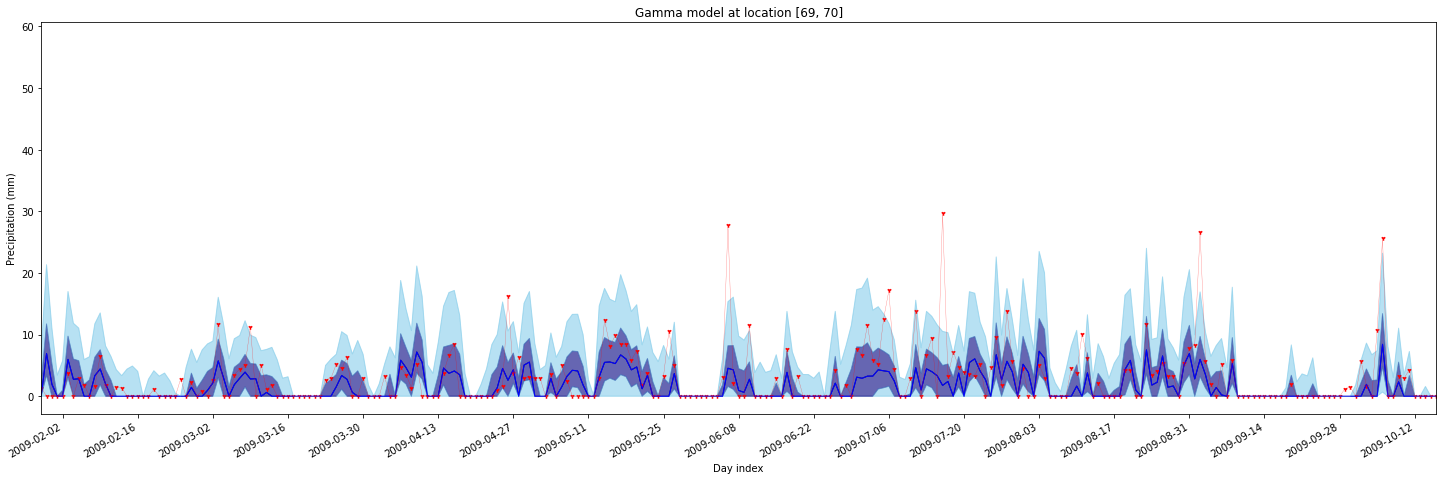

In [3]:
# Draw time-series plot with quantiles for predicted vs trget rain at a given location. ~3s 
# Just change values at the top.

ts_plot_location = 3055
ts_plot_left_lim,ts_plot_right_lim = 3500,3760

#################################################################### Do not touch the rest ####################################################################
import matplotlib.dates as mdates

# mean and 68, 95 percentiles 
g_median = []
g_q25 = []
g_q75 = []
g_q68 = []
g_q95 = []
g_q32 = []
g_q05 = []

#GNM_landonly[location][param][day]
## 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

#gamma_outputs [place][parameter][day][row][column]
# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.

for m,d,i in zip([GNM_landonly[ts_plot_location][0][i] for i in range(len(GNM_landonly[0][0]))],[GNM_landonly[ts_plot_location][1][i] for i in range(len(GNM_landonly[0][0]))],range(len(GNM_landonly[0][0]))) :
    rv = scs.gamma(scale=m*d,a=1/d)  
      
    g_median.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.5)/GNM_landonly[ts_plot_location][4][i]))
    g_q25.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.25)/GNM_landonly[ts_plot_location][4][i]))
    g_q75.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.75)/GNM_landonly[ts_plot_location][4][i]))
    g_q68.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.68)/GNM_landonly[ts_plot_location][4][i]))
    g_q95.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.95)/GNM_landonly[ts_plot_location][4][i]))
    g_q32.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.32)/GNM_landonly[ts_plot_location][4][i]))
    g_q05.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.05)/GNM_landonly[ts_plot_location][4][i]))

for q in [g_median,g_q25,g_q05,g_q32,g_q68,g_q75,g_q95]:
    for i in range(len(q)):
        if math.isnan(q[i]):
            q[i]=0
            
plt.figure(figsize=(25, 8))
plt.plot(day_dates,g_q05,color='skyblue',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_q25,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_median,color='blue',linewidth=1,alpha=1)
plt.plot(day_dates,g_q75,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_q95,color='skyblue',linewidth=0.6,alpha=0.3)
plt.fill_between(day_dates, g_median, g_q75, where=([g_median[k] < g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_median, g_q25, where=([g_median[k] > g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_q95, g_q75, where=([g_q95[k] > g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_q05, g_q25, where=([g_q05[k] < g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.scatter(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',marker='1',s=20)
plt.plot(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',alpha=0.6,linewidth=0.3)
plt.xlim((day_dates[ts_plot_left_lim],day_dates[ts_plot_right_lim]))
plt.title('Gamma model at location '+str(GNM_landonly[ts_plot_location][5]))
plt.xlabel('Day index')
plt.ylabel('Precipitation (mm)')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gcf().autofmt_xdate()
plt.show()

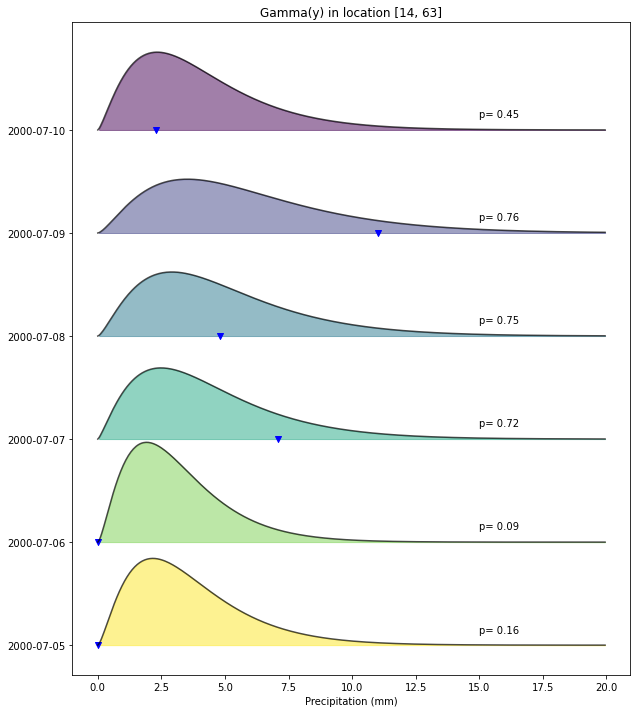

In [4]:
# Densities plots
# Just change values at the top.

density_plot_location = 111
density_plot_start,density_plot_end = 370,376

#################################################################### Do not touch the rest ####################################################################
import matplotlib

x=[i/20 for i in range(400)]
plt.figure(figsize=(10,(density_plot_end-density_plot_start)*2))
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(range(density_plot_end,density_plot_start,-1))))
for idx,col in zip(reversed(range(density_plot_start-1,density_plot_end)),colors):
    rv=scs.gamma(scale=[GNM_landonly[density_plot_location][1][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx]*[GNM_landonly[density_plot_location][0][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],a=1/[GNM_landonly[density_plot_location][1][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx])
    level=(-0.3+(idx+1-density_plot_start)*0.25)
    plt.plot(x,level+rv.pdf(x),color='black',alpha=0.7)
    plt.fill_between(x,y1=level+rv.pdf(x),y2=level,where=([level+rv.pdf(x_)>level for x_ in x]),color=col,alpha=0.5)
    plt.text(15,level+0.03,'p= '+str(round([GNM_landonly[density_plot_location][4][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],2)))
    plt.scatter([GNM_landonly[density_plot_location][3][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],level,marker='v',color='b')
plt.xlabel('Precipitation (mm)')
plt.title('Gamma(y) in location '+str(GNM_landonly[density_plot_location][5]))
plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],reversed([pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date'][density_plot_start:density_plot_end]]))
#plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],[k for k in range([density_plot_start:density_plot_end]])
plt.show()

In [124]:
subsample_of_days = np.random.choice(range(len(GNM_landonly[0][1])),size=400,replace=False)

# Simulation

sim_day = 400
sim_locations = range(len(GNM_landonly))
kernel_type = 'Matern'
theta_values = [800,10] # MLE gave [4.01,3.08]
nb_samples = 3

#################################################################### Do not touch the rest ####################################################################

# Utility function
def g_Finv(day_id,loc_id,u): # take u to a value of rain according to the gamma density for that day and location
    if 1-GNM_landonly[loc_id][4][day_id]>=u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=GNM_landonly[loc_id][1][day_id]*GNM_landonly[loc_id][0][day_id],a=1/GNM_landonly[loc_id][1][day_id]).ppf((u-1+GNM_landonly[loc_id][4][day_id])/GNM_landonly[loc_id][4][day_id])

# Define censor levels pi on normal scale := di. This is done for the whole dataset, no need to touch.

censored_di = [[GNM_landonly[loc][4][day] for loc in range(4087)] for day in tqdm(range(7031))] # di[day][loc]
censored_di = scs.norm.ppf(np.array(censored_di))

# Simulating Draws. Dependent on given day and locations.
simulated_us = truncgauss(dist_mat[:max(sim_locations),:max(sim_locations)]).sim(theta=theta_values,inv_us=censored_di,draws=nb_samples,day_idx=sim_day,kernel=kernel_type)

print('Simulations done!')

100%|██████████| 7031/7031 [00:06<00:00, 1066.15it/s]


Simulations done!


In [9]:
# Median rain forecasts for all days and locations
#GNM_landonly[location][param][day]


# Used to get the vectors for all locations and all times, not needed after that.
'''
g_median_all=[]

for loc in tqdm(range(len(GNM_landonly))):
    for day in range(len(GNM_landonly[0][1][:2000])):
        m,d = GNM_landonly[loc][0][day] , GNM_landonly[loc][1][day]
        rv = scs.gamma(scale=m*d,a=1/d)  
        g_median_all.append(rv.ppf((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day]))

g_median_all = np.nan_to_num(g_median_all,copy=True)

with open('g_median_all_20y_20y.txt','wb') as f:
    pickle.dump(g_median_all,f)

'''



    


with open('g_median_all_20y_20y.txt','rb') as f:
    g_median_all = pickle.load(f)
g_median_all_test = np.nan_to_num(g_median_all,nan=0)


In [26]:
def get_median(locs,nb_days):
    g_median_all_=[]
    for loc in locs:
        for day in range(nb_days):
            m,d = GNM_landonly[loc][0][day] , GNM_landonly[loc][1][day]
            rv = scs.gamma(scale=m*d,a=1/d)  
            g_median_all_.append(rv.ppf((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day]))

    

    return g_median_all_

In [3]:
def get_median(locs,nb_days):
    g_median_all_=[]
    for loc in locs:
        for day in range(nb_days):
            g_median_all_.append((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day])

    return g_median_all_

In [4]:
from joblib import Parallel, delayed
import psutil

size = math.ceil(len(GNM_landonly)/psutil.cpu_count())
locs_chuncks = [[i for i in range(len(GNM_landonly))][x:x+size] for x in range(0,len(GNM_landonly), size)]
print(size,psutil.cpu_count(),len(locs_chuncks))
list_g_median_all = Parallel(n_jobs=psutil.cpu_count())(delayed(get_median)(chunck[:2],2) for chunck in tqdm(locs_chuncks))

511 8 8


100%|██████████| 8/8 [00:00<00:00, 83.58it/s]
c:\Users\u1819911\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [5]:
# Spread-Skill but with variance as spread directly.
 
RMS_spread = [] # should get 2002 entries, each being the average RMS across all locations and draws, for that day.
RMS_skill = [] # should get 2002 entries, each being the average RMS across all locations, for that day.

for day in tqdm(range(len(GNM_landonly[0][1][:2000]))):
    # The expression used below is the RMS spread for one day: a single number, the average variance across all locations.
    RMS_spread.append(
        np.mean( # average over samples and locations 
             [(GNM_landonly[loc][4][day]*np.power(GNM_landonly[loc][0][day],2)*(GNM_landonly[loc][1][day]+1) - np.power(GNM_landonly[loc][4][day],2)*np.power(GNM_landonly[loc][0][day],2)) for loc in range(len(GNM_landonly))
                ]))
    
    # The expression below is the RMS skill for one day: a single number giving the average across all locations of the squared difference of median forecast and target
    RMS_skill.append(
        np.mean( # average over locations
            np.power( # square
                np.subtract( # difference
                    np.transpose(np.array(g_median_all).reshape((len(GNM_landonly),2000)))[day,:] # median for that day across all locations
                    ,[GNM_landonly[loc][3][day] for loc in range(len(GNM_landonly))] ) # target rain for that day across all locations
                    ,2) # square
                    ))

100%|██████████| 2000/2000 [02:14<00:00, 14.89it/s]


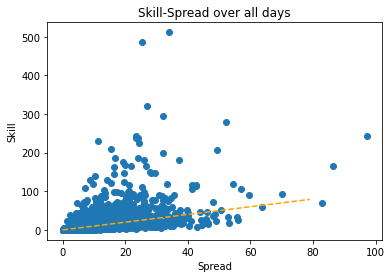

In [6]:
# Skill-Spread over all days
plt.scatter(RMS_spread,RMS_skill)
plt.plot(range(80),range(80),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')
plt.title('Skill-Spread over all days')
plt.show()

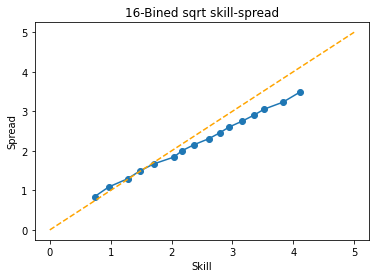

Text(0.5, 1.0, '16-Bined skill-spread')

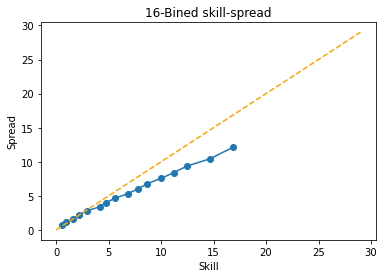

In [7]:
# 16-Bined skill-spread - Need to draw samples of u first. 
# They are then used for each day.
binned_skill = [math.sqrt(np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]
binned_spread = [math.sqrt(np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]

plt.plot(binned_skill,binned_spread,'-o')
plt.plot(range(6),range(6),color='orange',linestyle='--')
plt.xlabel('Skill')
plt.ylabel('Spread')
plt.title('16-Bined sqrt skill-spread')
#plt.xlim(10,25)
#plt.ylim(5,20)
plt.show()
binned_skill = [np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]
binned_spread = [np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]

plt.plot(binned_skill,binned_spread,'-o')
plt.plot(range(30),range(30),color='orange',linestyle='--')
plt.xlabel('Skill')
plt.ylabel('Spread')
plt.title('16-Bined skill-spread')